In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.tokenize import word_tokenize
from textblob import TextBlob
nltk.download('stopwords')

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manuelamiranda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Feature Engineering for User Data

# Creating Mock User Profiles for Music Recommendation Algorithm


In this part of our project, we aim to generate mock user profiles to facilitate the development and testing of a music recommendation algorithm. Our dataset comprises various features related to songs and playlists, including track IDs, names, artists, popularity, album information, playlist genres, and several musical attributes like danceability, energy, and tempo.


## Objective


The primary objective is to simulate realistic user behavior and preferences regarding their song choices. This simulation will enable us to train and evaluate our recommendation algorithm more effectively, ensuring it can handle real-world scenarios despite using synthetic data.


## Methodology


To create these mock user profiles, we will follow a structured approach that avoids random associations between users and songs. Random assignments might lead to unrealistic user profiles, which could adversely affect the training and performance of our recommendation model. Instead, we employ a K-Nearest Neighbors (KNN) algorithm to ensure that the song preferences attributed to each mock user are coherent and reflect plausible patterns of music consumption. This method involves:


1. **Feature Selection**: Using relevant musical attributes (e.g., danceability, energy) from our dataset to represent songs in a feature space.

2. **Clustering Songs**: Applying the KNN algorithm to group songs based on their similarity in the feature space. This step helps in mimicking how real users might prefer songs that are similar in certain musical aspects.

3. **Generating User Profiles**: Creating mock users by associating them with songs from specific clusters, thereby simulating user preferences for particular types of music. Each user's affinity to a song will be determined based on the proximity of the song to the user's preferred clusters.


## Implementation


We will implement this approach using Python's Pandas library for data manipulation and Scikit-learn for applying the KNN algorithm. This process will result in a set of mock user profiles with realistic song affinities, which can then be used to train and test our recommendation algorithm.


By ensuring that the mock user profiles reflect coherent musical preferences, we aim to create a robust foundation for developing an effective and accurate music recommendation system.


First we load the dataset and ensure we have no missing values

In [16]:
df = pd.read_csv('../datasets/song_data_postEDA_2.csv')
df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,playlist_name,playlist_id,playlist_genre,playlist_subgenre,...,acousticness,instrumentalness,liveness,valence,tempo,track_album_release_year,duration_minutes,track_name_preprocessed,playlist_name_sentiment,track_name_sentiment
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,2782,66,2oCs0DGTsRO98Gh5ZSl2Cx,7614,pop remix,37i9dQZF1DXcZDD7cfEKhW,2,3,...,0.1020,0.000000,0.0653,0.518,122.036,2019,3.25,care justin bieber loud luxury remix,0.0,0.10
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,6084,67,63rPSO264uRjW1X5E6cWv6,10410,pop remix,37i9dQZF1DXcZDD7cfEKhW,2,3,...,0.0724,0.004210,0.3570,0.693,99.972,2019,2.71,memories dillon francis remix,0.0,0.00
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,10416,70,1HoSmj2eLcsrR0vE9gThr4,985,pop remix,37i9dQZF1DXcZDD7cfEKhW,2,3,...,0.0794,0.000023,0.1100,0.613,124.008,2019,2.94,time diablo remix,0.0,0.00
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,9215,60,1nqYsOef1yKKuGOVchbsk6,2798,pop remix,37i9dQZF1DXcZDD7cfEKhW,2,3,...,0.0287,0.000009,0.2040,0.277,121.956,2019,2.82,call mine keanu silva remix,0.0,0.00
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,5402,69,7m7vv9wlQ4i0LFuJiE2zsQ,14843,pop remix,37i9dQZF1DXcZDD7cfEKhW,2,3,...,0.0803,0.000000,0.0833,0.725,123.976,2019,3.15,someone loved future humans remix,0.0,0.35


In [17]:
df.isnull().sum()

track_id                    0
track_name                  0
track_artist                0
track_popularity            0
track_album_id              0
track_album_name            0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
track_album_release_year    0
duration_minutes            0
track_name_preprocessed     0
playlist_name_sentiment     0
track_name_sentiment        0
dtype: int64

Now I'm going to encode the track name and the playlist name so I can proceed with my KNN clustering of the songs.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tfidf_vectorizer_track = TfidfVectorizer()
tfidf_vectorizer_playlist = TfidfVectorizer()

track_name_tfidf = tfidf_vectorizer_track.fit_transform(df['track_name_preprocessed'])

playlist_name_tfidf = tfidf_vectorizer_playlist.fit_transform(df['playlist_name'])

df_tdidf = df.copy()
df_tdidf['track_name_vectorized'] = list(track_name_tfidf.toarray())
df_tdidf['playlist_name_vectorized'] = list(playlist_name_tfidf.toarray())

In [19]:
df_tdidf.dtypes

track_id                     object
track_name                   object
track_artist                  int64
track_popularity              int64
track_album_id               object
track_album_name              int64
playlist_name                object
playlist_id                  object
playlist_genre                int64
playlist_subgenre             int64
danceability                float64
energy                      float64
key                           int64
loudness                    float64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
track_album_release_year      int64
duration_minutes            float64
track_name_preprocessed      object
playlist_name_sentiment     float64
track_name_sentiment        float64
track_name_vectorized        object
playlist_name_vectorized     object
dtype: object

In [22]:
df_tdidf.drop(df_tdidf.select_dtypes(include=['object']).columns, axis=1, inplace=True)
df_tdidf.head()

,track_artist,track_popularity,track_album_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_album_release_year,duration_minutes,playlist_name_sentiment,track_name_sentiment
0,2782,66,7614,2,3,0.748,0.916,6,-2.634,0.0583,0.1020,0.000000,0.0653,0.518,122.036,2019,3.25,0.0,0.10
1,6084,67,10410,2,3,0.726,0.815,11,-4.969,0.0373,0.0724,0.004210,0.3570,0.693,99.972,2019,2.71,0.0,0.00
2,10416,70,985,2,3,0.675,0.931,1,-3.432,0.0742,0.0794,0.000023,0.1100,0.613,124.008,2019,2.94,0.0,0.00
3,9215,60,2798,2,3,0.718,0.930,7,-3.778,0.1020,0.0287,0.000009,0.2040,0.277,121.956,2019,2.82,0.0,0.00
4,5402,69,14843,2,3,0.650,0.833,1,-4.672,0.0359,0.0803,0.000000,0.0833,0.725,123.976,2019,3.15,0.0,0.35


PARA HACERLO MEJOR, TENGO QUE VER COMO IMPLEMENTAR TDIDF PARA QUE ME TOME EL PLAYLIST NAME EN CONSIDERACION

Now we normalize our data to prepare for clustering

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [23]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_tdidf)

We try to find the most optimal number of clusters based on the silhouette score

For n_clusters = 10, the silhouette score is: 0.0666
For n_clusters = 15, the silhouette score is: 0.0611
For n_clusters = 20, the silhouette score is: 0.0574
For n_clusters = 25, the silhouette score is: 0.0546
For n_clusters = 30, the silhouette score is: 0.0528


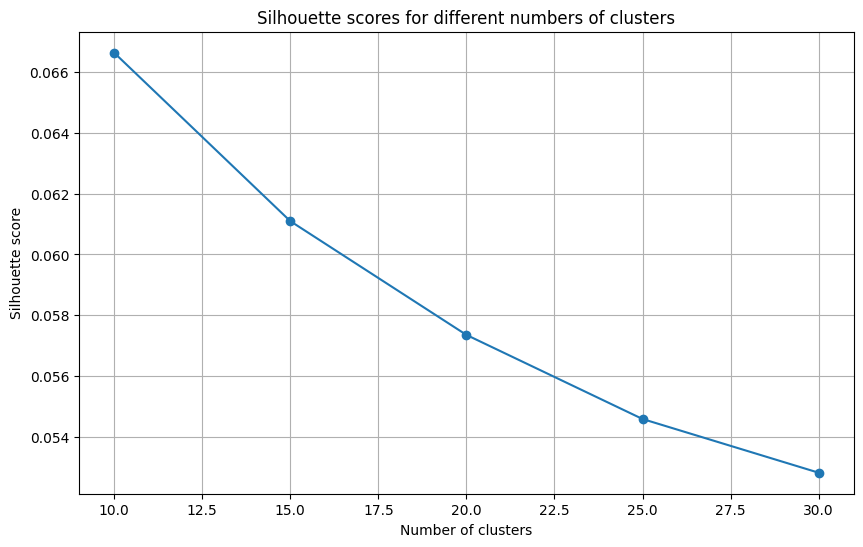

In [37]:
# Example range of cluster numbers to evaluate
range_n_clusters = [10, 15, 20, 25, 30]

silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    # Initialize KMeans with the current number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)
    
    # Calculate the silhouette score for the current number of clusters
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    
    # Print the silhouette score
    print(f"For n_clusters = {n_clusters}, the silhouette score is: {silhouette_avg:.4f}")

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')
plt.title('Silhouette scores for different numbers of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.grid(True)
plt.show()


As seen, the scores are not great but also not bad (needs to be improved). We will go with 20 clusters to keep a good enough silhouette score without reducing the number of clusters as much

Silhouette Score for 20 clusters: 0.06


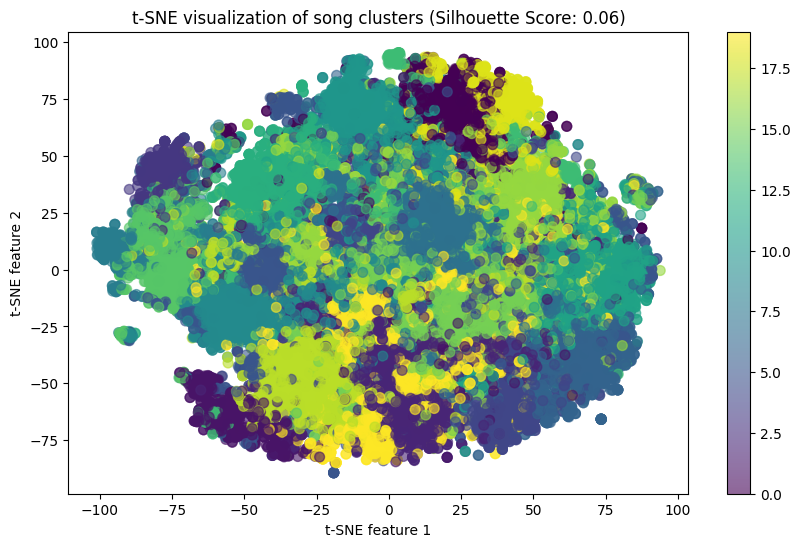

In [30]:
# Assuming features_scaled is your scaled feature set ready for clustering
n_clusters = 20

# Apply KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)

# Calculate silhouette score
silhouette_avg = silhouette_score(features_scaled, df['cluster'])
print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg:.2f}")

# Visualizing the Clusters with t-SNE
tsne = TSNE(n_components=2, random_state=42)  # Added random_state for reproducibility
tsne_results = tsne.fit_transform(features_scaled)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df['cluster'], cmap='viridis', s=50, alpha=0.6)
plt.colorbar()
plt.title(f't-SNE visualization of song clusters (Silhouette Score: {silhouette_avg:.2f})')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

Now we will create the new dataframe for the songs assigned to each user

In [33]:
num_users = 50
user_preferences = {f'{i}': np.random.choice(range(20), size=np.random.randint(1, 6), replace=False) for i in range(num_users)}

# Initialize an empty DataFrame for storing user-song assignments
columns = ['user_id'] + list(df.columns)  # Define the columns for the new DataFrame
user_song_df = pd.DataFrame(columns=columns)  # Create the DataFrame

# Assign songs to users based on their cluster preferences
for user_id, prefs in user_preferences.items():
    # Filter songs that match the user's preferences
    preferred_songs_df = df[df['cluster'].isin(prefs)]
    
    # If you want to limit the number of songs per user, adjust the number in .sample(n=...)
    # Here, it's dynamically set to min(10, len(preferred_songs_df))
    sampled_songs_df = preferred_songs_df.sample(n=min(50, len(preferred_songs_df)), replace=True)
    
    # Add a 'user_id' column to the sampled songs DataFrame
    sampled_songs_df['user_id'] = user_id
    
    # Append the user's sampled songs to the main user_song_df DataFrame
    user_song_df = pd.concat([user_song_df, sampled_songs_df], ignore_index=True)

# Reorder the DataFrame to have 'user_id' as the first column
user_song_df = user_song_df[['user_id'] + [col for col in user_song_df.columns if col != 'user_id']]

# Now user_song_df contains each song assigned to a user, including the user_id and all song-related columns


/var/folders/2d/3hctyjd51cn5wc76s6w7g2d00000gn/T/ipykernel_3539/408037628.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  user_song_df = pd.concat([user_song_df, sampled_songs_df], ignore_index=True)


In [34]:
user_song_df.head(70)

,user_id,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,playlist_name,playlist_id,playlist_genre,...,instrumentalness,liveness,valence,tempo,track_album_release_year,duration_minutes,track_name_preprocessed,playlist_name_sentiment,track_name_sentiment,cluster
0,0,6F5c58TMEs1byxUstkzVeM,Roar,4897,77,5MQBzs5YlZlE28mD9yUItn,12217,top hits,2DjIfVDXGYDgRxw7IJTKVb,0,...,0.000007,0.3540,0.4550,179.984,2013,3.73,roar,0.5000,0.0,1
1,0,2gT8OWcAgPg0yawg1qw4Nv,Loma de Cayenas,9965,51,7gSN3OHB6q52ivR61esxSe,2889,paraiso tropical,37i9dQZF1DWYey22ryYM8U,1,...,0.000000,0.0969,0.9640,129.955,2019,3.80,loma de cayenas,0.0000,0.0,19
2,0,24b20V609aI0WJ8LyxR8qx,The Game & Skrillex: El Chapo,9286,60,19tRwHQ4ZoKnwa1S8zB041,16308,rap gangsta,1Z1gW89x4MSBjkvVjGg7DQ,4,...,0.000000,0.2810,0.5910,126.994,2015,3.67,game skrillex el chapo,0.0000,-0.4,19
3,0,6wyr4ReB05D9sJB1Rsmcqo,Chicken Noodle Soup (feat. Becky G),10569,76,76IRLp7YzBVLKsat6Ro9ae,3141,indie,6MQeEHHDs6HQkN5Dlj3oKo,2,...,0.000011,0.2940,0.1680,97.053,2019,3.92,chicken noodle soup feat becky g,0.0000,-0.6,19
4,0,1hZJcuz9iMoz6tLkFlIaUy,Take My Breath Away,1005,60,1gwQ8OK1YHKpzIxLKuc1MQ,15747,songs top music hits,65HtIbyFkaQPflCa4oW8KO,2,...,0.000310,0.1240,0.5110,95.892,2007,4.40,take breath away,0.5000,0.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,1,6EZbZORN2AfvPbBqOCVwq9,Slammer,7589,38,7A70TDQLlAqSrKmZblX3BA,14635,big room beast,3PNyCpkY7NAXyhopBpj7vc,0,...,0.739000,0.0452,0.0464,128.044,2014,4.75,slammer,0.0000,0.0,14
66,1,0gsDBm94QELEJAcGS59f1b,Flashbacks,6093,52,0xi4cOWPUHjctyYU8ypCOB,8470,trap mojito,37i9dQZF1DX1OIMC8iDi74,4,...,0.698000,0.1110,0.4270,142.031,2018,2.76,flashbacks,0.0000,0.0,14
67,1,5o84LEb5HomrkUXZPrQJJH,Living On Video,3486,16,0vNHurgZCXw61BbimvPQcJ,3834,gym melbourne house,5BqOZpVEqRDfZScvW1QUyA,0,...,0.680000,0.2070,0.5480,131.026,2010,3.31,living video,0.0000,0.0,14
68,1,0X108Ku9IS4s8f4IndB9c6,You Better Be Mine,10009,18,6jpH2EH914G5ysVLaATkqZ,19158,edm trap,7CEEEMKV41x0RlFCXWdvKF,0,...,0.000001,0.2540,0.1940,92.034,2017,3.53,better mine,0.0000,0.5,12


In [36]:
user_song_df.to_csv('user_song_df2.csv', index=False)